In [ ]:
from google.colab import drive
import zipfile
import os


In [ ]:

# Mount Google Drive
drive.mount('/content/drive')

# Path to the zip file in your Google Drive
zip_file_path = '/content/drive/MyDrive/PDS_PROJECT/seg.zip'

# Directory to extract the files to
extracted_dir = '/content/seg_data'

# Create directory if it doesn't exist
if not os.path.exists(extracted_dir):
    os.makedirs(extracted_dir)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

print("Extraction complete.")



Mounted at /content/drive
Extraction complete.


In [ ]:
!pip install -U spektral


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 3.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Dense, GlobalMaxPooling1D, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model
import cv2
import glob

In [ ]:
# Define a custom GraphConvolution layer
class GraphConvolution(Layer):
    def __init__(self, units, activation=None):
        super(GraphConvolution, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.units])

    def call(self, inputs):
        return self.activation(tf.matmul(inputs, self.kernel))


In [ ]:

# Function to load and preprocess images
def load_images(directory):
    images = []
    labels = []
    for folder in os.listdir(directory):
        for file in glob.glob(os.path.join(directory, folder, '*.jpg')):
            image = cv2.imread(file)
            image = cv2.resize(image, (64, 64))  # Resize image to fit model input shape
            images.append(image)
            labels.append(folder)
    return np.array(images), np.array(labels)


In [ ]:
# Load training and test images
train_images, train_labels = load_images('/content/seg_data/seg_test/seg_test')
test_images, test_labels = load_images('/content/seg_data/seg_train/seg_train')

In [ ]:
# Normalize pixel values to [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Initialize label encoder
label_encoder = LabelEncoder()

# Convert string labels to integer labels
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Split training data into training and validation sets
train_images, val_images, train_labels_encoded, val_labels_encoded = train_test_split(train_images, train_labels_encoded, test_size=0.2, random_state=42)


In [ ]:
# Define the GCN model
def create_gcn_model(input_shape, num_classes):
    # Define input layer
    inputs = Input(shape=input_shape)

    # Add convolutional layers
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = GraphConvolution(128, activation='relu')(x)
    # Add dense layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Add output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the data generator
datagen.fit(train_images)

In [ ]:
# Create GCN model
gcn_model = create_gcn_model(train_images.shape[1:], len(np.unique(train_labels)))

# Compile GCN model
gcn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the GCN model with data augmentation
history = gcn_model.fit(datagen.flow(train_images, train_labels_encoded, batch_size=32),
                        epochs=40, validation_data=(val_images, val_labels_encoded))

# Evaluate the GCN model
test_loss, test_accuracy = gcn_model.evaluate(test_images, test_labels_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/40
75/75 [==============================] - 20s 251ms/step - loss: 1.5464 - accuracy: 0.3592 - val_loss: 1.3233 - val_accuracy: 0.4767
Epoch 2/40
75/75 [==============================] - 20s 265ms/step - loss: 1.2495 - accuracy: 0.5025 - val_loss: 1.2131 - val_accuracy: 0.5317
Epoch 3/40
75/75 [==============================] - 18s 234ms/step - loss: 1.1851 - accuracy: 0.5387 - val_loss: 1.0567 - val_accuracy: 0.5800
Epoch 4/40
75/75 [==============================] - 18s 238ms/step - loss: 1.0866 - accuracy: 0.5742 - val_loss: 1.0581 - val_accuracy: 0.5950
Epoch 5/40
75/75 [==============================] - 18s 241ms/step - loss: 1.0509 - accuracy: 0.6058 - val_loss: 1.0259 - val_accuracy: 0.6150
Epoch 6/40
75/75 [==============================] - 19s 255ms/step - loss: 0.9892 - accuracy: 0.6229 - val_loss: 1.1006 - val_accuracy: 0.6017
Epoch 7/40
75/75 [==============================] - 18s 237ms/step - loss: 0.9650 - accuracy: 0.6367 - val_loss: 1.0730 - val_accuracy: 0.6117

439/439 [==============================] - 37s 83ms/step


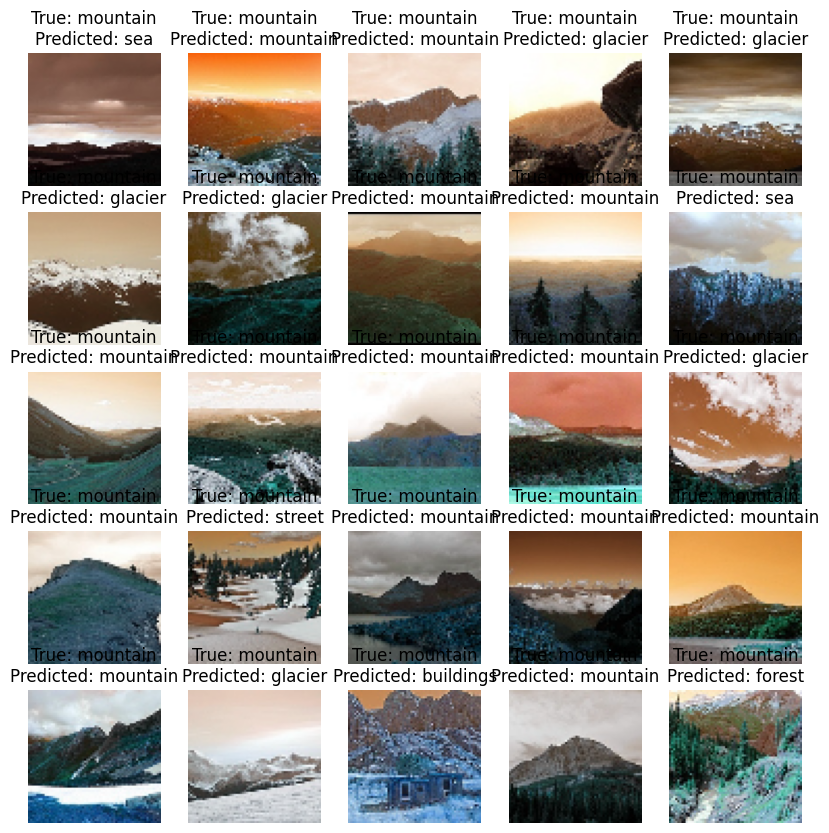

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images with labels
def display_images_with_labels(images, true_labels, predicted_labels):
    num_images = len(images)
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f'True: {true_labels[i]}\nPredicted: {predicted_labels[i]}')
        plt.axis('off')
    plt.show()

# Make predictions on the test set
predicted_labels_encoded = gcn_model.predict(test_images)
predicted_labels = label_encoder.inverse_transform(np.argmax(predicted_labels_encoded, axis=1))

# Display first 25 images with true and predicted labels
display_images_with_labels(test_images[:25], test_labels[:25], predicted_labels[:25])
